### インポート

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### タイタニックデータのロード

In [83]:
train_df = pd.read_csv('./titanic/train.csv')
test_df = pd.read_csv('./titanic/test.csv')

In [84]:
# データサイズ確認
train_df.shape

(891, 12)

In [85]:
# 問題データも確認
test_df.shape

(418, 11)

### 読み込んだデータ確認

In [86]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [87]:
# モデル作成用データの情報を確認
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


| データの情報 | 列名 |　意味 |
| ----- | ----- | ----- |
| int | PassengerId | 乗客ID |
| int | **Pclass** | チケットの等級 (1, 2, 3) |
| int | SibSp | 同乗した兄弟姉妹/配偶者の人数 |
| int | Parch | 同乗した両親/子供の人数 |
| int | *Survived* | 0：死亡、1：生存 |
| float | **Age** | 年齢（推測があるため、浮動小数点数） |
| float | Fare | 運賃 |
| object | Name | 氏名 |
| object | **Sex** | 性別 |
| object | Ticket | チケット番号 |
| object | Cabin | 船室番号　|
| object | **Embarked** | 乗船した港の頭文字(S, Q, C) |


### データ変換と補完

補完するに当たって、相関性が気になる。  
補完対象は、Age(年齢), Cabin(船室番号), Embarked(乗船した港) とのこと。  
偏見で、船室番号って、生存率に関わってないか？

という事でグラフにしてみる。

/Users/armeria/.pyenv/versions/anaconda3-5.3.0/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


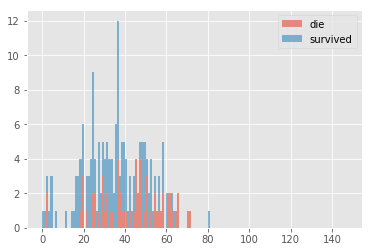

In [92]:
temp_df = train_df.dropna(subset=['Cabin'])

cabin_indexes = {}
cabin_cur_idx = 0
def to_cabin_id(v):
    global cabin_cur_idx
    if v not in cabin_indexes.keys():
        cabin_indexes[v] = cabin_cur_idx
        cabin_cur_idx += 1
    return cabin_indexes[v]

temp_df['Cabin'].sort_values()
temp_df['Cabin'] = temp_df['Cabin'].apply(to_cabin_id)
ｐｌｔ.hist([temp_df[(temp_df['Survived'] == 0)]['Age'],
          temp_df[(temp_df['Survived'] == 1)]['Age']],
        alpha=0.6, range=(0,cabin_cur_idx), bins=cabin_cur_idx, stacked=True, label=('Died', 'Survived'))
plt.legend(['die', 'survived'])
plt.show()

うわ、複数船室とかめんどくさくて辞書順ソートして見たけど、船室番号で生存率に有意差がありそうだ。  
でもテストデータ的に 418 レコード中入ってるの 91 だけなんだよな…ううむ…  
もったいないけど使いにくいので除去。

30% を超えて損失あるデータを補完して使うのは、余程他の項目と相関があると分析できない限り、誤差が激しすぎるので厳しいと思う。